In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
anime = pd.read_csv('../input/anime-recommendations-database/anime.csv')
ratings = pd.read_csv('../input/anime-recommendations-database/rating.csv')

In [3]:
data = pd.merge(ratings, anime, on='anime_id')
data = data.dropna()
data = data.drop('rating_y', axis=1)
data.rename(columns = {'rating_x':'rating'}, inplace = True)
data = data[data['rating'] != -1]
data

,user_id,anime_id,rating,name,genre,type,episodes,members
1,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
2,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
5,21,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
6,28,20,9,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
7,34,20,9,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
...,...,...,...,...,...,...,...,...
7813720,65175,30095,7,Qi Cai Lao Fu Zi,"Action, Comedy, Seinen",Movie,1,82
7813721,65175,30096,7,Lao Fu Zi Shui Hu Chuan,"Comedy, Historical, Seinen",Movie,1,65
7813722,65682,30450,8,Dr. Slump: Hoyoyo! Arale no Himitsu Dai Koukai...,"Comedy, Sci-Fi, Shounen",Special,1,248
7813723,69497,33484,10,Shiroi Zou,"Action, Historical, Kids",Movie,1,45


## Анализ жанров

Чтобы определить, что смотрят нынче анимешники, сначала вытащим все жанры аниме

In [4]:
dirty_genre_list = list(set(data.genre))
genre_list = list(set([g for x in dirty_genre_list for g in x.split(', ')]))
pd.Series(genre_list)

0             Ecchi
1            Sports
2              Kids
3      Supernatural
4         Shoujo Ai
5             Drama
6            Seinen
7           Fantasy
8              Cars
9              Yaoi
10           Sci-Fi
11           Parody
12         Thriller
13          Mystery
14    Psychological
15       Historical
16             Yuri
17            Mecha
18            Magic
19             Game
20           Comedy
21            Space
22     Martial Arts
23       Shounen Ai
24      Super Power
25          Romance
26        Adventure
27           Police
28           Shoujo
29            Harem
30          Vampire
31           Hentai
32            Music
33           School
34           Demons
35         Dementia
36           Horror
37          Shounen
38         Military
39          Samurai
40            Josei
41    Slice of Life
42           Action
dtype: object

Теперь проанализируем, сколько фильмов в каждом жанре

In [5]:
stats_df = pd.DataFrame(columns=['Жанр', 'Число фильмов'])
stats_df['Жанр'] = genre_list
stats_df['Число фильмов'] = 0

for g in list(set(data.genre)):
    for genre in g.split(', '):
        stats_df.loc[stats_df['Жанр'] == genre, 'Число фильмов'] += 1
    
stats_df = stats_df.sort_values(by='Число фильмов', ascending=False)

In [6]:
stats_df

,Жанр,Число фильмов
20,Comedy,1221
42,Action,1134
10,Sci-Fi,803
5,Drama,795
26,Adventure,779
7,Fantasy,761
25,Romance,744
37,Shounen,636
3,Supernatural,567
33,School,453


<AxesSubplot:xlabel='Жанр'>

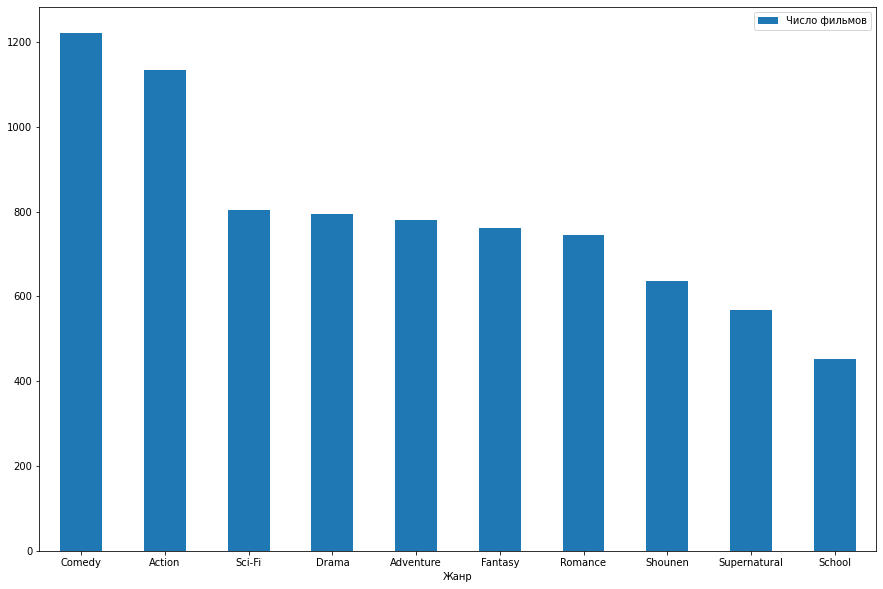

In [7]:
stats_df.set_index('Жанр').head(10).plot(kind='bar', figsize=(15, 10), rot=0)

## Выведение средней оценки аниме

Датасет предоставляет данные о отзывах людей о разных аниме, можно воспользоваться этим и найти среднее значение для каждого тайтла

In [8]:
mean_df = pd.DataFrame(columns=['Фильм', 'Средняя оценка'])
mean_df['Фильм'] = list(set(data['name']))
mean_df['Средняя оценка'] = list(data.groupby('name')['rating'].mean().round(2))
mean_df = mean_df.sort_values(by='Средняя оценка', ascending=False)
mean_df

,Фильм,Средняя оценка
4330,Cinderella Boy,10.0
6492,Baby Princess 3D Paradise 0 [Love],10.0
3223,Tatakae! Chou Robot Seimeitai Transformers,10.0
3213,Teekyuu 5 Specials,10.0
1275,Hikenai Guitar wo Hikundaze,10.0
...,...,...
4240,Gundam Build Fighters Try,1.0
9517,Ojousama wa H ga Osuki: The Animation,1.0
4263,Genroku Koi Moyou: Sankichi to Osayo,1.0
8584,Stairs: Houkago no Album,1.0


## Предсказание оценки на аниме

В датасете есть небольшое число признаков (`genre`, `type`, `episodes`, `members`), на основе которых можно попробовать предсказать отзыв человека. Введем целевую переменную

In [9]:
target_variable_name = 'rating'

Данные в датасете неотформатированны, в связи с чем модель будет выдавать ошибку. Исправим это

In [10]:
anime_df = anime
anime_df = anime_df.dropna()
anime_df['genre'] = anime_df['genre'].agg(lambda x: x.split(', '))
anime_df = anime_df[anime_df["episodes"].str.contains("Unknown") == False]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
type_data = list(set(anime_df['type'].values))
labelencoder = LabelEncoder()
anime_df['type'] = labelencoder.fit_transform(anime_df['type'])

In [12]:
genre_columns = list(map(lambda x: 'genre_' + x, genre_list)) ## Создадим отдельный столбец для каждого жанра

for genre in genre_columns:
    anime_df[genre] = 0

for i, v in enumerate(anime_df['genre'].values):
    for genre in genre_list:
        if genre in v:
            anime_df.loc[anime_df['genre_' + genre], i] = 1 ## Укажем принадлежность к жанру в нужной ячейке

anime_df = anime_df.drop('genre', axis=1) ## Избавимся от лишнего столбца

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


Отделим тренировочные данные и значения

In [13]:
y = anime_df[target_variable_name]
X = anime_df.drop(target_variable_name, axis=1)[['type', 'episodes', 'members'] + genre_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [14]:
X_train

,type,episodes,members,genre_Ecchi,genre_Sports,genre_Kids,genre_Supernatural,genre_Shoujo Ai,genre_Drama,genre_Seinen,...,genre_School,genre_Demons,genre_Dementia,genre_Horror,genre_Shounen,genre_Military,genre_Samurai,genre_Josei,genre_Slice of Life,genre_Action
11436,3,1,2563,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3460,3,2,3993,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9534,5,26,160,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7865,4,1,2889,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8507,1,1,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11734,3,2,1489,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5219,4,3,2371,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5420,3,2,21805,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
863,0,1,58184,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Обучим модель

In [15]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Получим набор предсказаний

In [16]:
y_pred = model.predict(X_test)
y_pred

array([6.35463962, 6.09166648, 6.35448788, ..., 6.36470709, 6.36442517,
       6.63862111])

Также было бы неплохо узнать значение MAE и MSE:

In [17]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

MSE: 0.8675144277172485
MAE: 0.7191412804821699


Результаты не очень хорошие. Поскольку к исходному датасету были добавлены столбцы, отвечающие за отдельный жанр, получилась ситуация, в которой много признаков, имеющих нулевое значение. Есть подозрение, что этот факт сказывается на качестве предсказаний. Потенциальное решение - использовать больше **разных** признаков, а также оставить лишь 1 жанр для тайтла. Давайте узнаем, какой вес у каждого признака

### Анализ важности признаков

In [18]:
linear_weights = abs(model.coef_)

feature_importance = pd.DataFrame(columns = ['Название признака', 'Важность признака'])
feature_importance['Название признака'] = X_test.columns
feature_importance['Важность признака'] = linear_weights
feature_importance.sort_values(by='Важность признака', ascending=False)

,Название признака,Важность признака
0,type,0.104826
1,episodes,0.000353
2,members,0.000007
44,genre_Slice of Life,0.000000
25,genre_Martial Arts,0.000000
26,genre_Shounen Ai,0.000000
27,genre_Super Power,0.000000
28,genre_Romance,0.000000
29,genre_Adventure,0.000000
30,genre_Police,0.000000


Я оказался прав

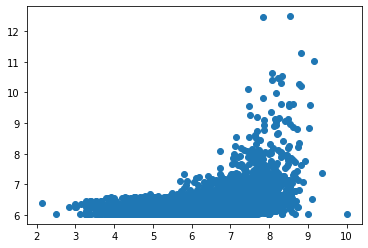

In [19]:
plt.scatter(y_test, y_pred)